In [28]:
from transformers import AutoProcessor, HubertModel, HubertForCTC, Wav2Vec2FeatureExtractor
import torch
import librosa
import numpy as np
import simpsom as sps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [6]:
neut_audio = "../data/crowd/crowd_test/wavs/d49a6b560155831725a7bdc7d0a96099.wav"
angry_audio = "../data/crowd/crowd_test/wavs/4bd5a9c05848ff92c9a002d92604714f.wav"
sad_audio = "../data/crowd/crowd_test/wavs/95449782aef0f663064737a594824887.wav"
pos_audio = "../data/crowd/crowd_test/wavs/64a7aa17132c3e4b7be1aaed5fc88090.wav"

audio_list = [neut_audio, angry_audio, sad_audio, pos_audio]

## Base model

In [3]:
model_name = "facebook/hubert-base-ls960"
model = HubertModel.from_pretrained(
    model_name,
    output_hidden_states=True
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [9]:
def get_output_for_audio(audio, feature_extractor, model, sampling_rate=16000):
    audio_array = librosa.load(
        audio,
        sr=sampling_rate,
        mono=False
    )[0]
    
    input_values = feature_extractor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_values

    output = model(input_values)

    return output

def get_hidden_states(audio_list, model, feature_extractor, sampling_rate=16000):
    hidden_states = []
    labels = []
    i = 0
    for audio in audio_list:
        output = get_output_for_audio(audio, feature_extractor, model, sampling_rate)
        hidden_states.append(output.hidden_states)
        labels += [i for _ in range(hidden_states[-1][0].shape[1])]
        i += 1
    return hidden_states, labels

In [39]:
labels = []
i = 0
output_features = []
audio_list = [neut_audio, angry_audio, sad_audio, pos_audio]
sampling_rate = 16000
hidden_states = []
for audio in audio_list:
    output = get_output_for_audio(audio, feature_extractor, model, sampling_rate)
    hidden_states.append(output.hidden_states)
    # output_features.append(output.last_hidden_state.detach().numpy()[0])
    labels += [i for _ in range(hidden_states[-1][0].shape[1])]
    i += 1

# data = output_features[0]
# for i in range(1, len(output_features)):
    # data = np.concatenate((data, output_features[i]))

torch.Size([1, 218, 768])
torch.Size([1, 184, 768])
torch.Size([1, 128, 768])
torch.Size([1, 252, 768])


In [26]:
def apply_clustering(data, n_clusters):
    k_means = KMeans(init="k-means++", n_init=15, n_clusters=n_clusters)
    k_means_labels = k_means.fit_predict(data)
    return k_means, k_means_labels

def plot_clustering_results(data, true_labels, clustering_labels):
    pca = PCA(n_components=2)
    pca.fit(data)
    pca_data = pca.transform(data)
    
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    
    axs[0].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=true_labels, cmap='viridis')
    axs[0].set_title('Исходные метки')
    
    axs[1].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=clustering_labels, cmap='viridis')
    axs[1].set_title('K-Means')
    
    plt.tight_layout()
    plt.show()


Номер слоя: 1
0.2870353016085153


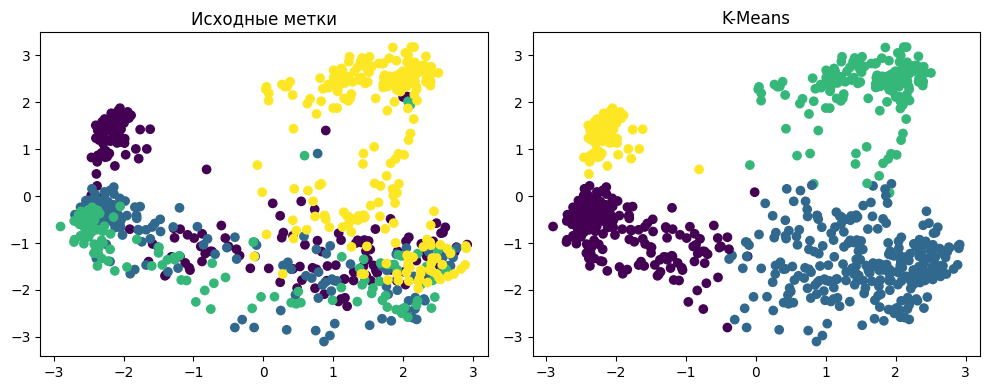

Номер слоя: 2
0.19115414990267962


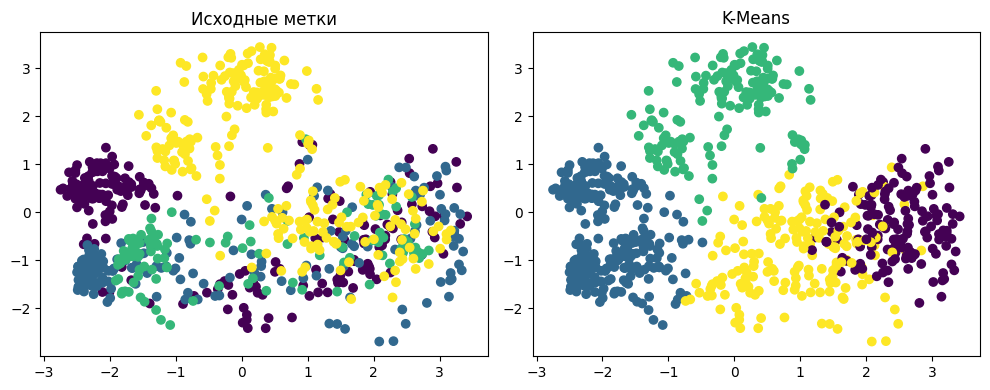

Номер слоя: 3
0.08921428361472927


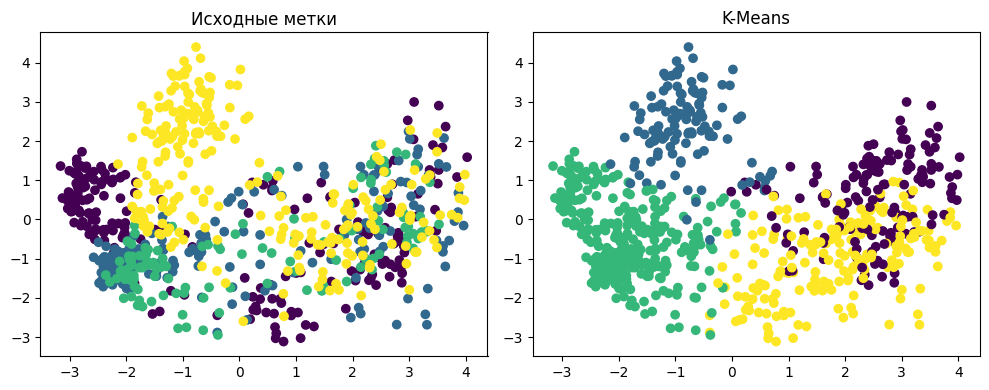

Номер слоя: 4
0.09557866598718467


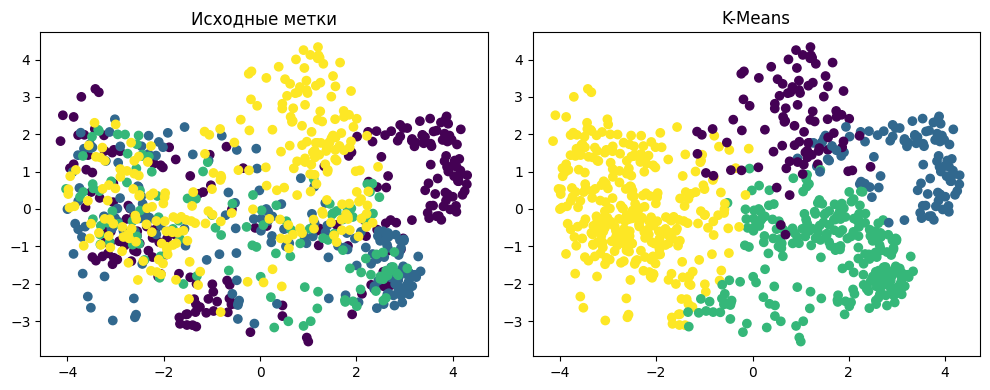

Номер слоя: 5
0.06308765270298733


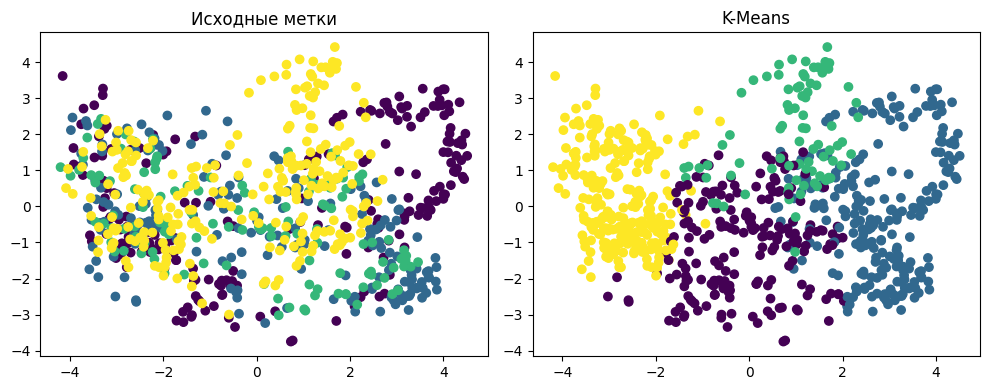

Номер слоя: 6
0.06518757369638527


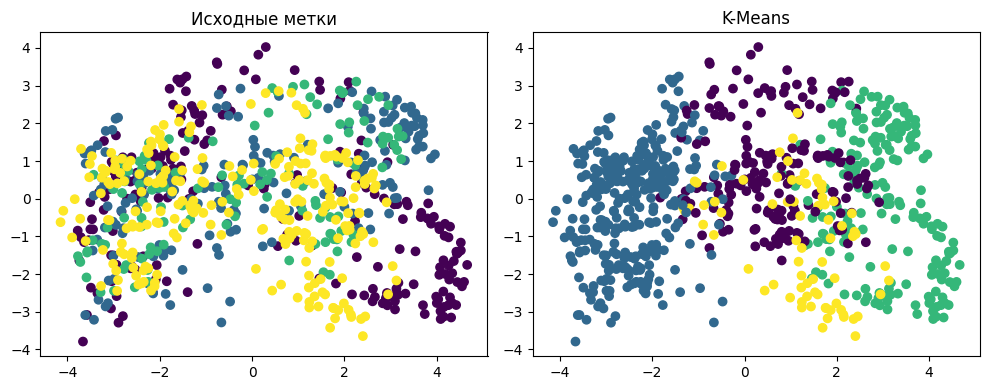

Номер слоя: 7
0.007477388259484368


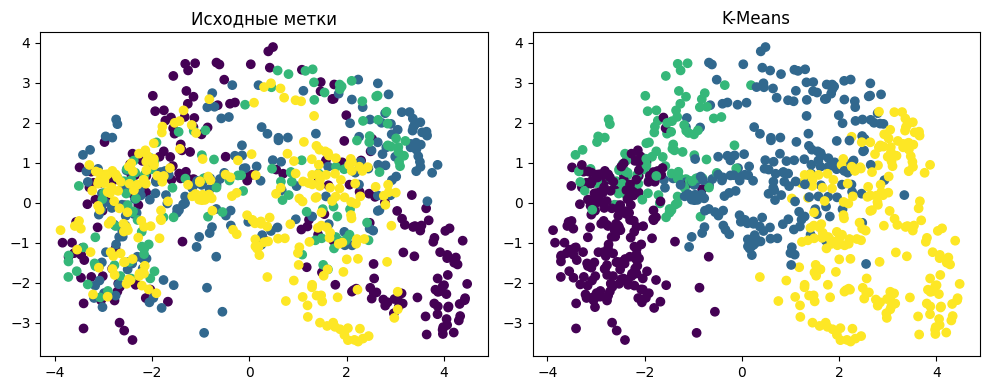

Номер слоя: 8
0.020030058367930086


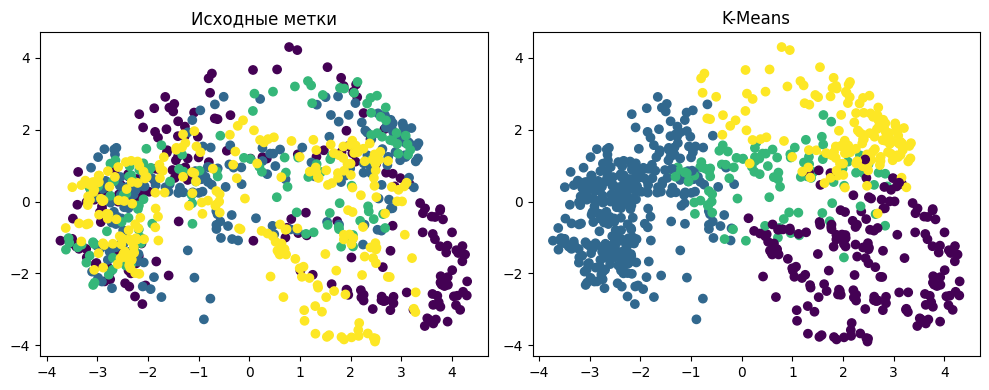

Номер слоя: 9
0.024390496911234516


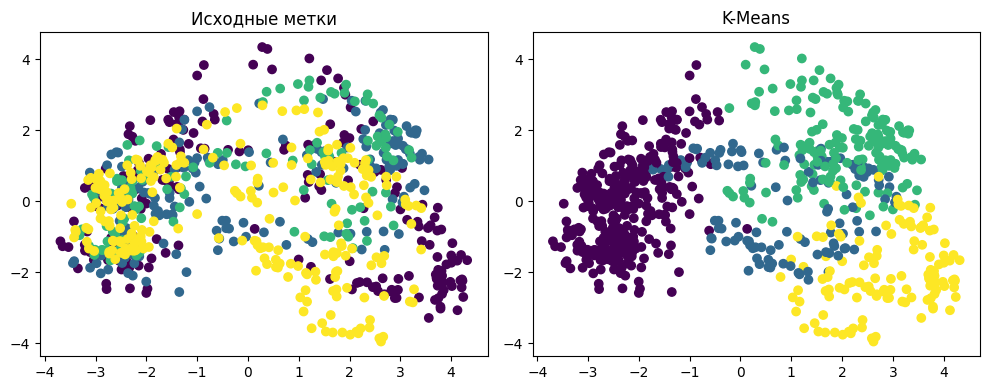

Номер слоя: 10
0.025661023125659974


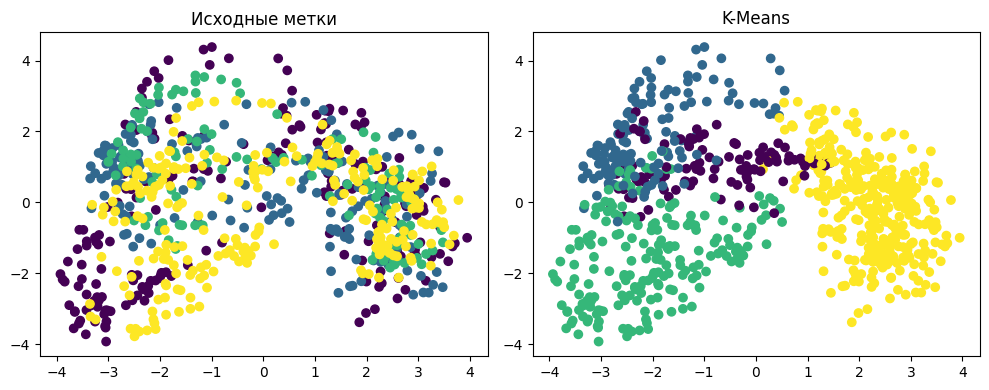

Номер слоя: 11
0.03345193190389575


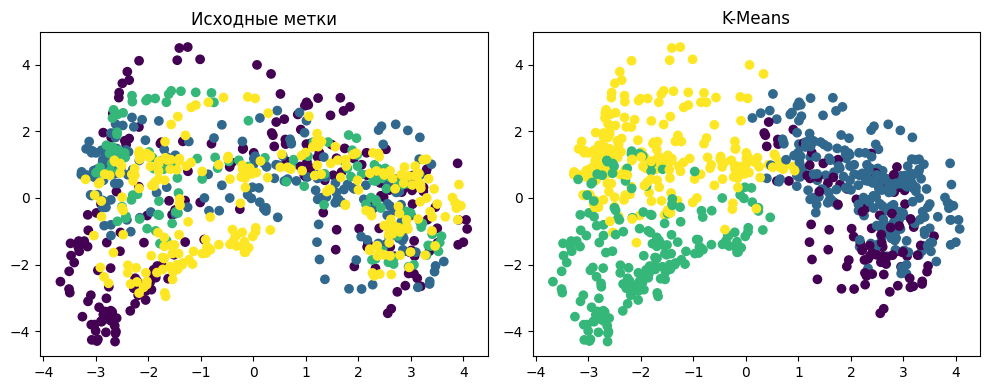

Номер слоя: 12
0.04001691409521502


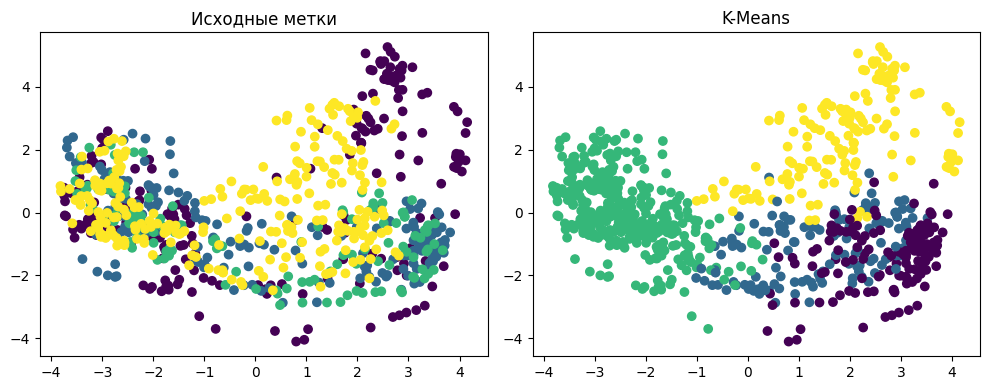

Номер слоя: 13
0.03279733534923943


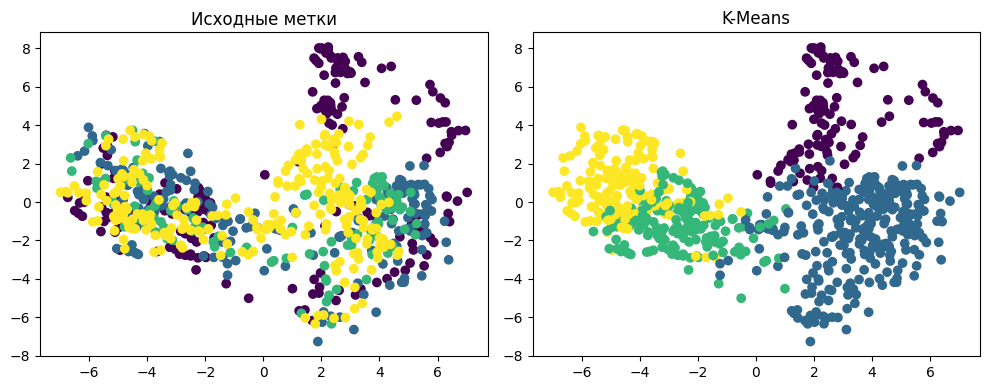

In [52]:
for i in range(len(hidden_states[0])):
    print(f'Номер слоя: {i + 1}')

    data = hidden_states[0][i].detach().numpy()[0]
    for j in range(1, len(hidden_states)):
        data = np.concatenate((data, hidden_states[j][i].detach().numpy()[0]))

    k_means, k_means_labels = apply_clustering(data, 4)
    print(adjusted_rand_score(labels, k_means_labels))
    plot_clustering_results(data, labels, k_means_labels)


In [55]:
data_1_layer = hidden_states[0][0].detach().numpy()[0]
for j in range(1, len(hidden_states)):
    data_1_layer = np.concatenate((data_1_layer, hidden_states[j][0].detach().numpy()[0]))

k_means_4, k_means_4_labels = apply_clustering(data_1_layer, 4)
k_means_5, k_means_5_labels = apply_clustering(data_1_layer, 5)

# neut 218
# angry 184
# sad 128
# pos 252

neut_data = data_1_layer[0:218]
angry_data = data_1_layer[218:402]
sad_data = data_1_layer[402:530]
pos_data = data_1_layer[530:]

def print_labels_distribution(data, cluster_model, n_clusters):
    labels = cluster_model.predict(data)
    for label in range(n_clusters):
        print(f'{label}: {list(labels).count(label) / len(labels)}')

print('4 кластера')

print('neutral audio')
print_labels_distribution(neut_data, k_means_4, 4)


print('angry audio')
print_labels_distribution(angry_data, k_means_4, 4)


print('sad audio')
print_labels_distribution(sad_data, k_means_4, 4)


print('positive audio')
print_labels_distribution(pos_data, k_means_4, 4)

print('\n5 кластеров')

print('neutral audio')
print_labels_distribution(neut_data, k_means_5, 5)

print('angry audio')
print_labels_distribution(angry_data, k_means_5, 5)

print('sad audio')
print_labels_distribution(sad_data, k_means_5, 5)

print('positive audio')
print_labels_distribution(pos_data, k_means_5, 5)

4 кластера
neutral audio
0: 0.3302752293577982
1: 0.15137614678899083
2: 0.5
3: 0.01834862385321101
angry audio
0: 0.33695652173913043
1: 0.657608695652174
2: 0.0
3: 0.005434782608695652
sad audio
0: 0.34375
1: 0.6328125
2: 0.0
3: 0.0234375
positive audio
0: 0.3492063492063492
1: 0.003968253968253968
2: 0.0
3: 0.6468253968253969

5 кластеров
neutral audio
0: 0.20642201834862386
1: 0.5
2: 0.01834862385321101
3: 0.13302752293577982
4: 0.14220183486238533
angry audio
0: 0.16847826086956522
1: 0.0
2: 0.005434782608695652
3: 0.1956521739130435
4: 0.6304347826086957
sad audio
0: 0.1796875
1: 0.0
2: 0.0234375
3: 0.15625
4: 0.640625
positive audio
0: 0.15476190476190477
1: 0.0
2: 0.6428571428571429
3: 0.20238095238095238
4: 0.0


## Large model

In [4]:
model_name = "facebook/hubert-large-ll60k"
model = HubertModel.from_pretrained(
    model_name,
    output_hidden_states=True
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

C:\Study\clustering-methods\venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MIKHAIL\.cache\huggingface\hub\models--facebook--hubert-large-ll60k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-large-ll60k were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-large-ll60k and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for p

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [10]:
hidden_states, labels = get_hidden_states(audio_list, model, feature_extractor, 16000)

Номер слоя: 0
0.1981591608021586


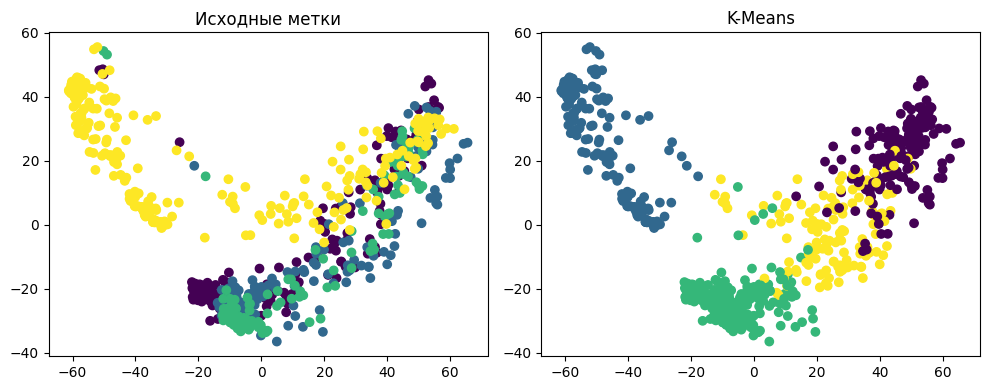

Номер слоя: 1
0.08329106644267369


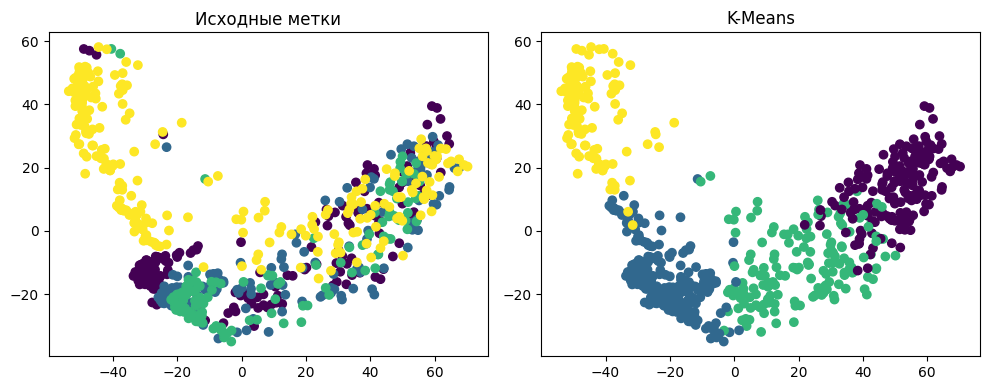

Номер слоя: 2
0.08176546775157392


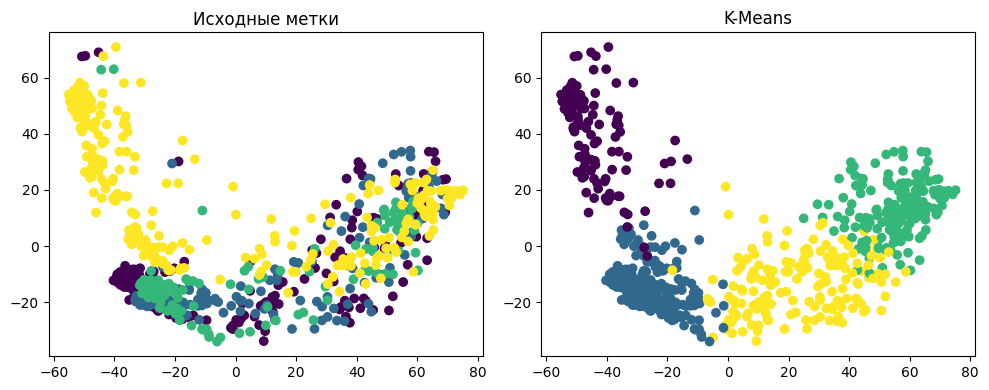

Номер слоя: 3
0.07884104989503601


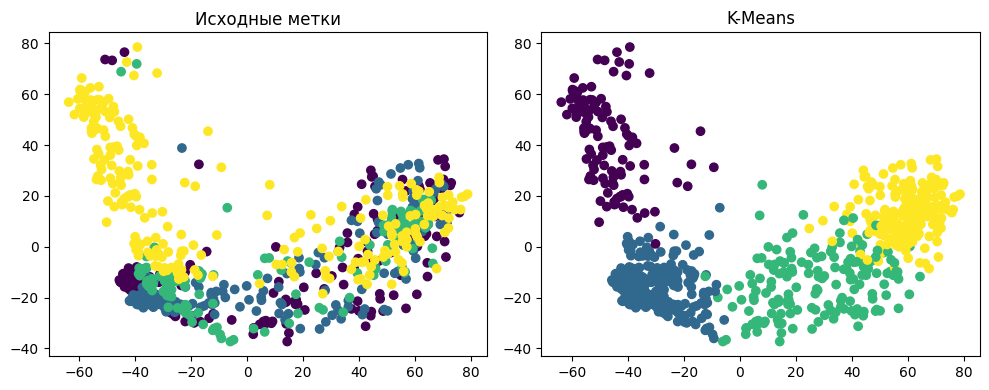

Номер слоя: 4
0.06976097639255449


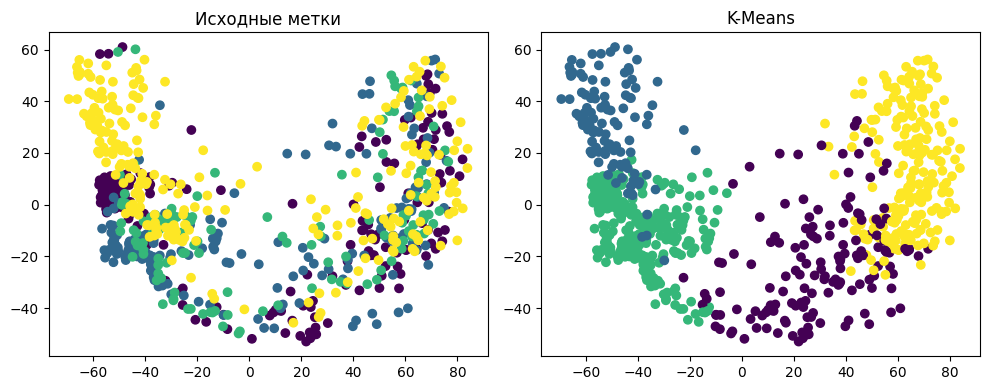

Номер слоя: 5
0.18695531275266075


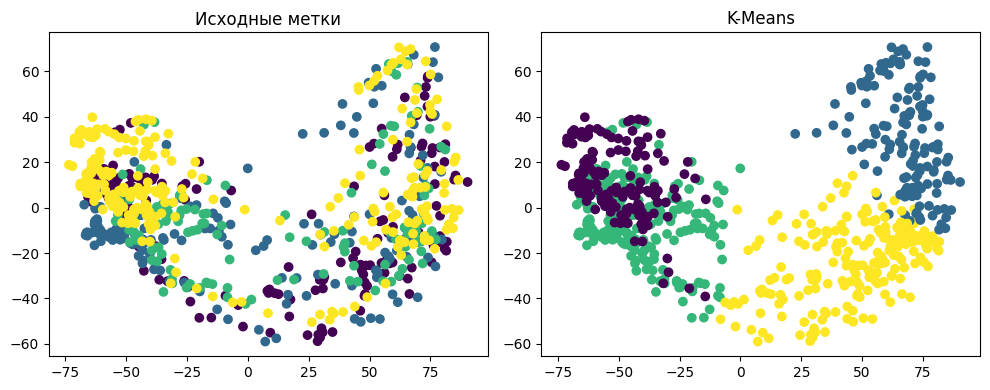

Номер слоя: 6
0.17681603191489595


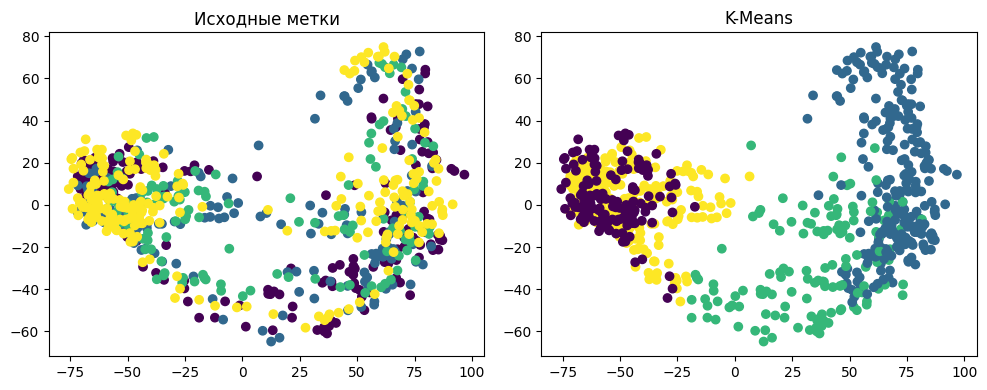

Номер слоя: 7
0.18287826100417637


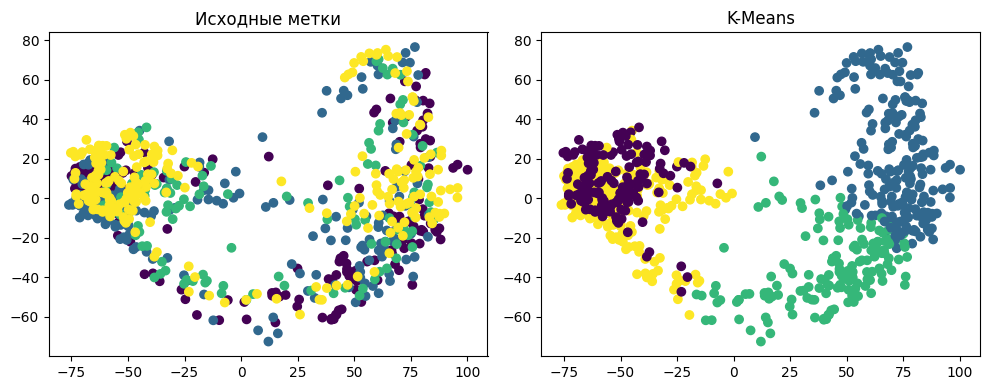

Номер слоя: 8
0.17789947823804683


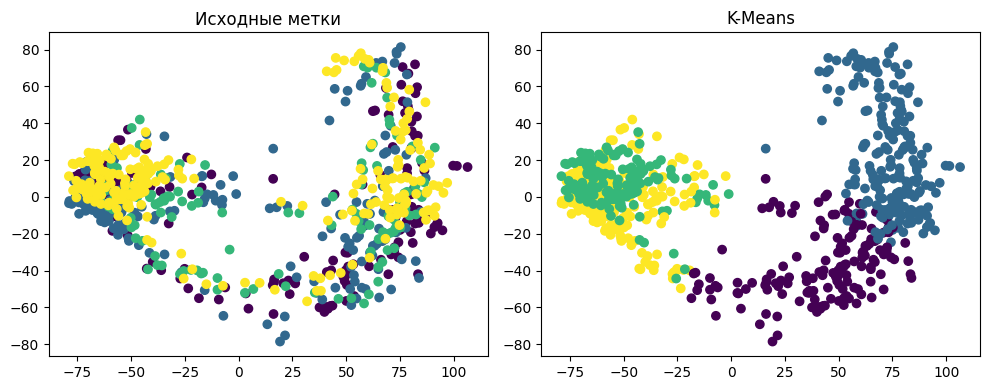

Номер слоя: 9
0.04424584684206913


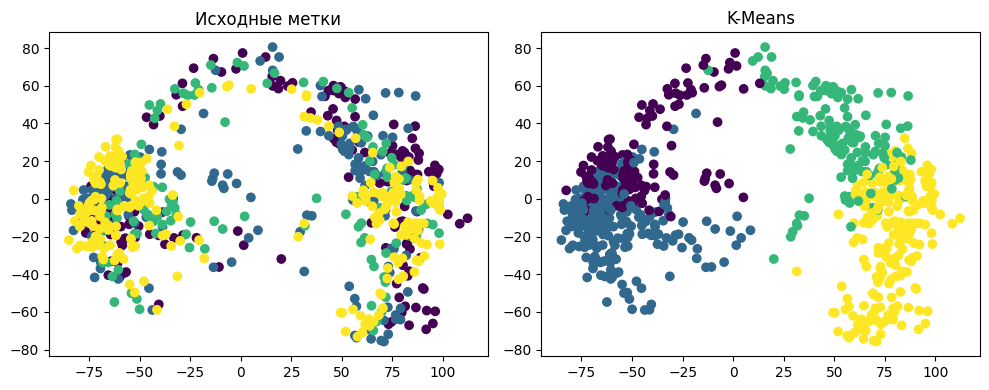

Номер слоя: 10
0.018447475077518087


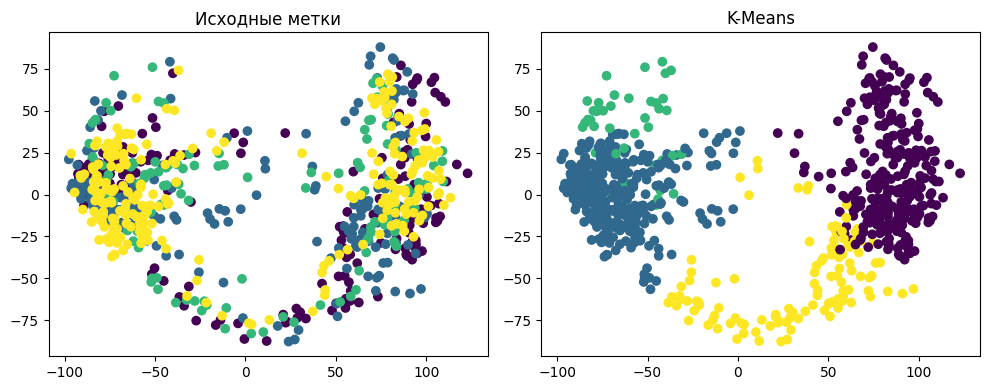

Номер слоя: 11
0.009578228390919848


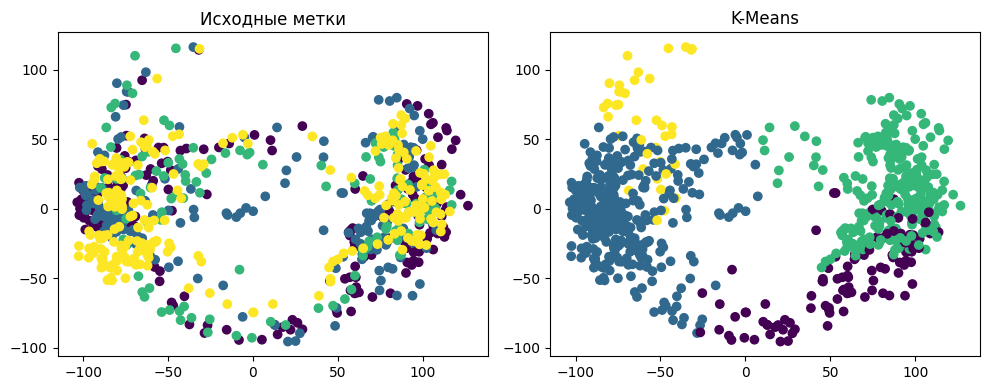

Номер слоя: 12
0.02226556228917842


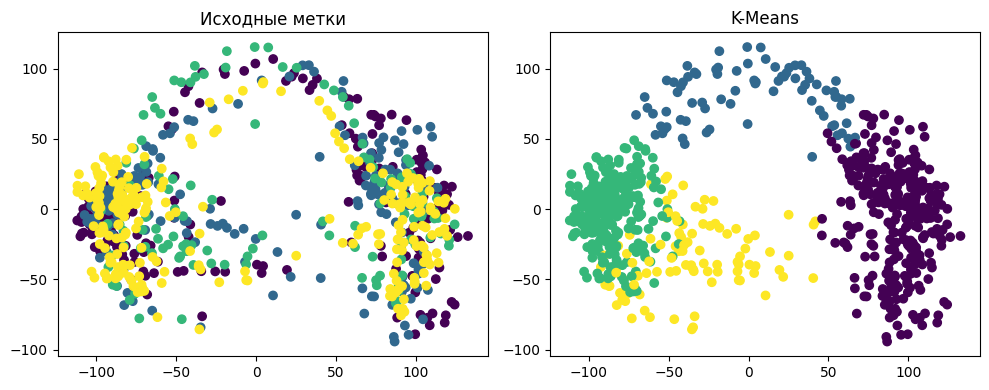

Номер слоя: 13
0.013459239639791485


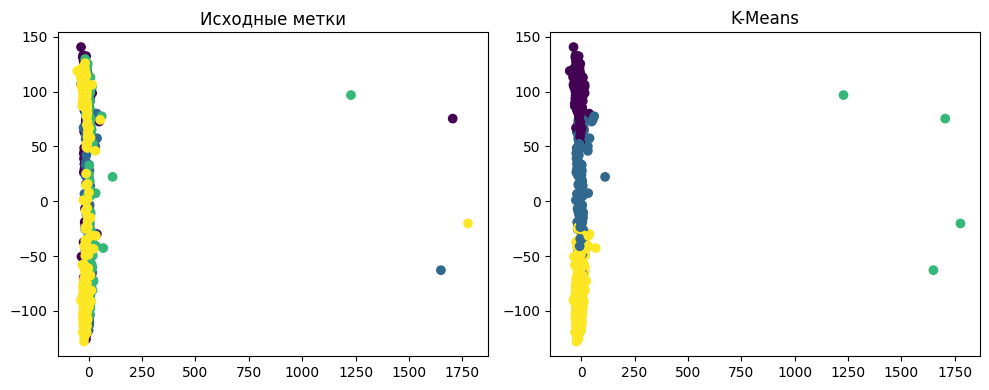

Номер слоя: 14
0.013544831448880421


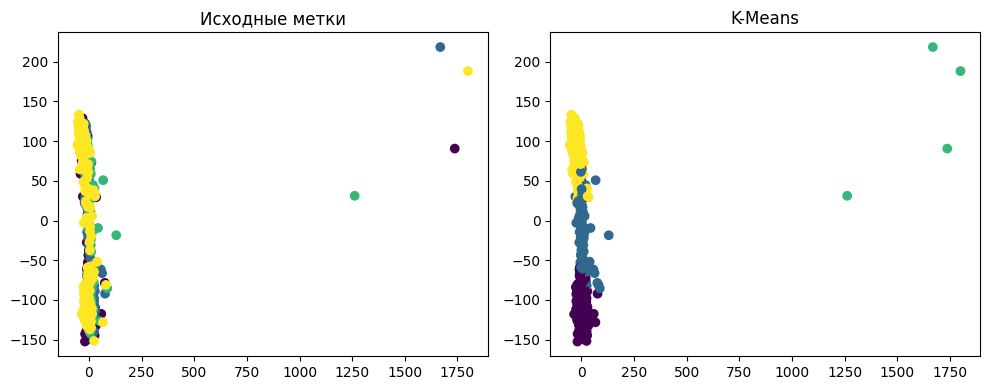

Номер слоя: 15
0.00305987036929456


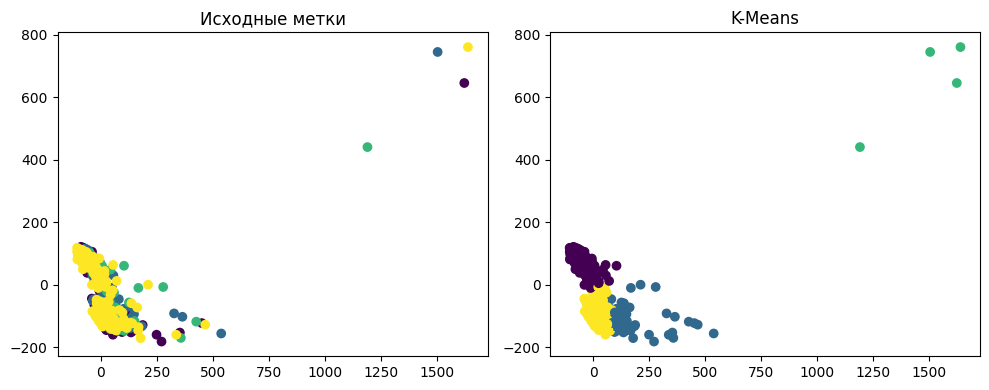

Номер слоя: 16
0.003098584224402641


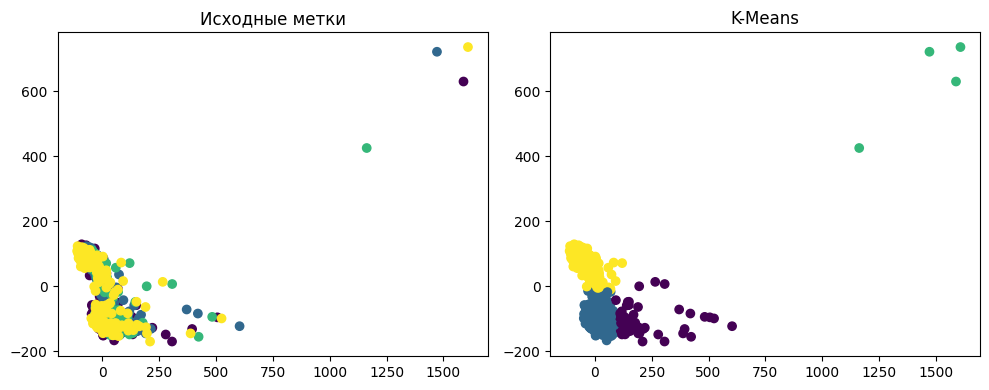

Номер слоя: 17
0.0023544191180528275


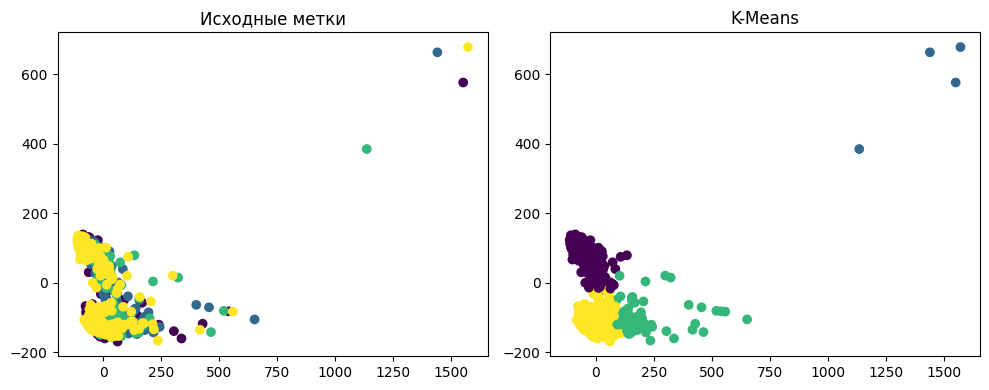

Номер слоя: 18
0.0018502168658993691


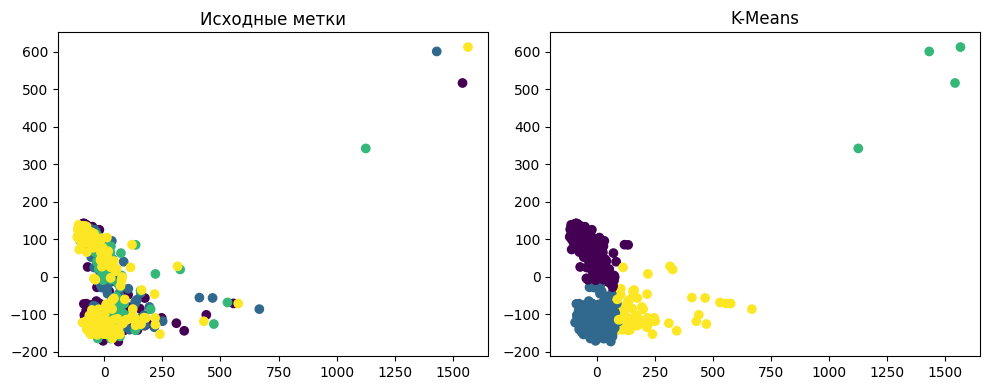

Номер слоя: 19
0.0039325644200282365


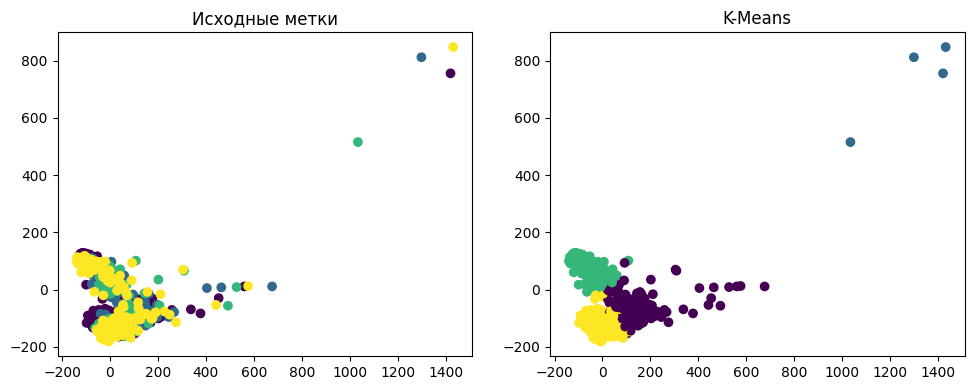

Номер слоя: 20
0.003930416153386189


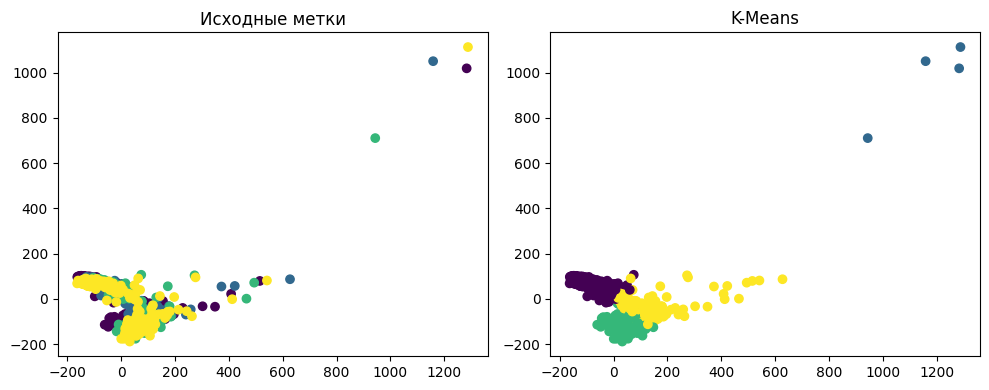

Номер слоя: 21
0.00801588231439615


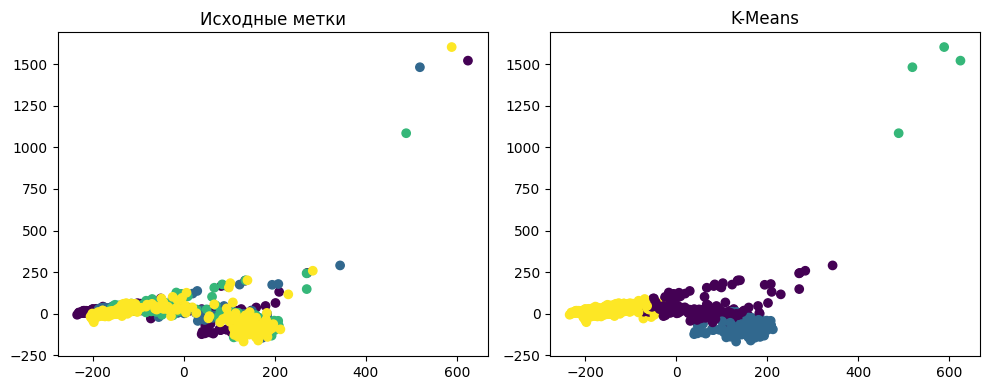

Номер слоя: 22
0.006926983652010364


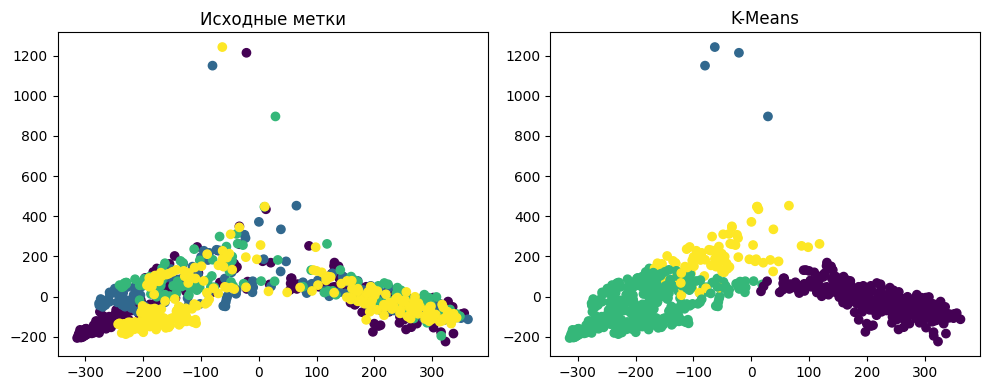

Номер слоя: 23
0.0667076721787054


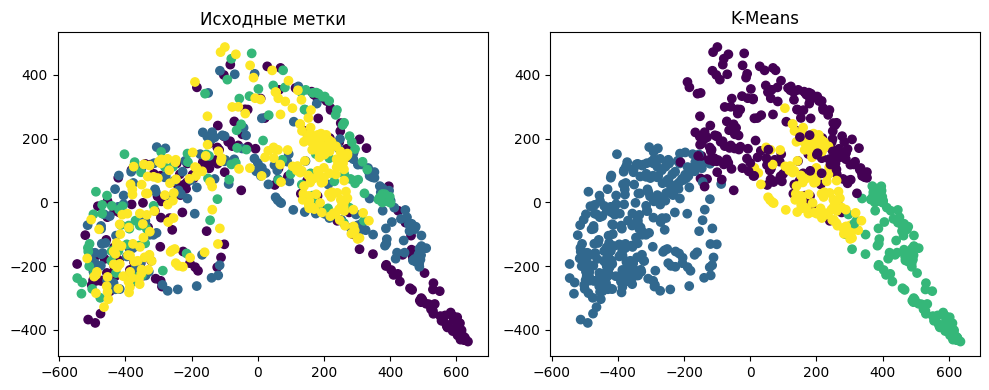

Номер слоя: 24
0.032588558062144196


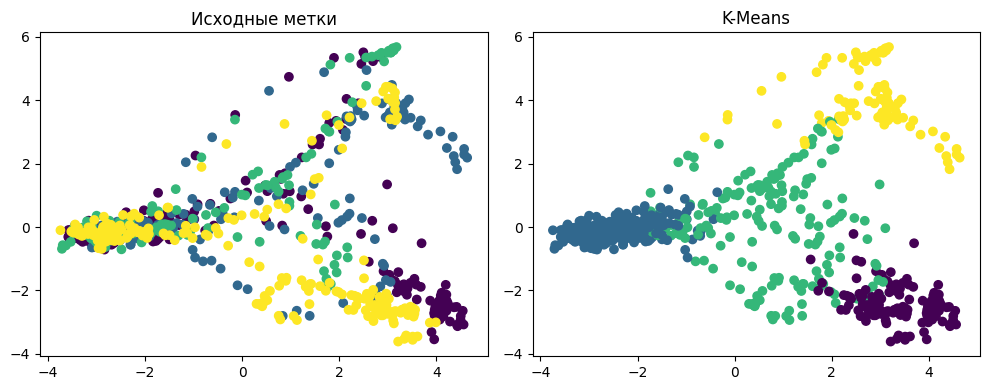

In [30]:
k_means_labels_for_layers = []
for i in range(len(hidden_states[0])):
    print(f'Номер слоя: {i}')

    data = hidden_states[0][i].detach().numpy()[0]
    for j in range(1, len(hidden_states)):
        data = np.concatenate((data, hidden_states[j][i].detach().numpy()[0]))

    k_means, k_means_labels = apply_clustering(data, 4)
    print(adjusted_rand_score(labels, k_means_labels))
    k_means_labels_for_layers.append(k_means_labels)
    plot_clustering_results(data, labels, k_means_labels)

## -------------------------------------------

In [5]:
import simpsom as sps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [6]:
k_means = KMeans(init="k-means++", n_init=15, n_clusters=5)
k_means_labels = k_means.fit_predict(data)
print(adjusted_rand_score(labels, k_means_labels))

0.04165004747385309


In [7]:
pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)

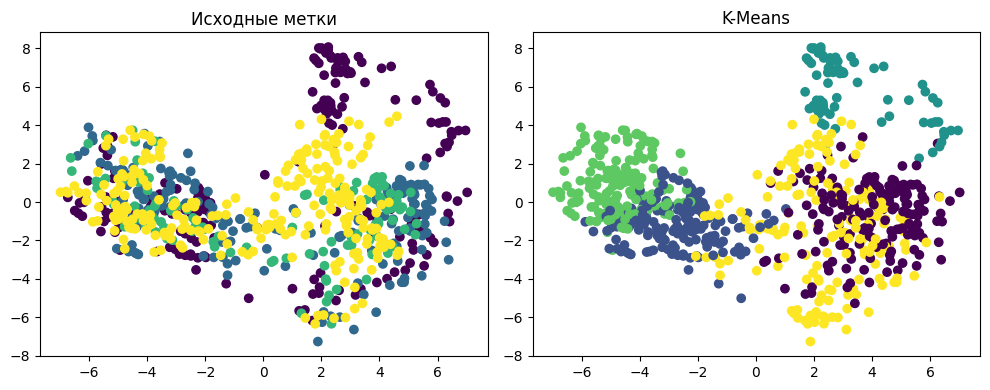

In [8]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)

axs[0].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=labels, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=k_means_labels, cmap='viridis')
axs[1].set_title('K-Means')

plt.tight_layout()
plt.show()

2024-09-30 18:46:34.926 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-09-30 18:46:34.927 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-09-30 18:46:34.929 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-09-30 18:46:34.930 | INFO     | simpsom.network:train:396 - Early stop active.
2024-09-30 18:46:34.931 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
C:\Study\clustering-methods\venv\Lib\site-packages\simpsom\distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2024-09-30 18:46:35.082 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


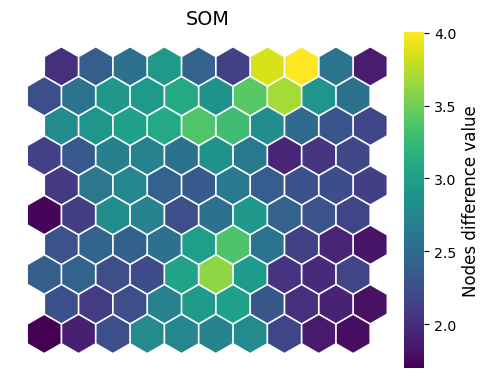

2024-09-30 18:46:35.356 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-09-30 18:46:35.417 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


0.039737777266271694


In [7]:
som = sps.SOMNet(10, 10, data, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=False, CUML=False,
                 debug=False)

som.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som.plot_map_by_difference(show=True, print_out=False)

som_labels, _ = som.cluster(data, algorithm='KMeans', n_clusters=4)
print(adjusted_rand_score(labels, som_labels))

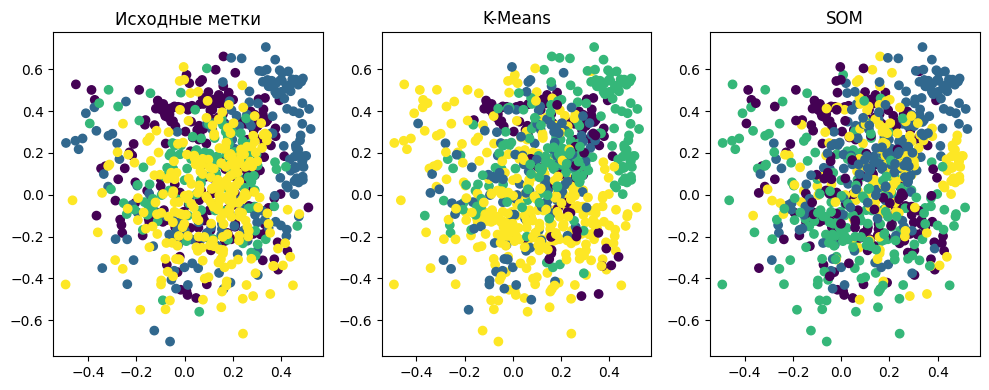

In [8]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(10)

axs[0].scatter(x=data[:, 0], y=data[:, 1], c=labels, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=data[:, 0], y=data[:, 1], c=k_means_labels, cmap='viridis')
axs[1].set_title('K-Means')

axs[2].scatter(x=data[:, 0], y=data[:, 1], c=som_labels, cmap='viridis')
axs[2].set_title('SOM')

plt.tight_layout()
plt.show()

In [9]:
pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)

In [10]:
k_means_pca = KMeans(init="k-means++", n_init=15, n_clusters=4)
k_means_pca_labels = k_means_pca.fit_predict(pca_data)
print(adjusted_rand_score(labels, k_means_pca_labels))

0.025269453199649527


2024-09-30 18:46:35.951 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-09-30 18:46:35.952 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-09-30 18:46:35.956 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-09-30 18:46:35.957 | INFO     | simpsom.network:train:396 - Early stop active.
2024-09-30 18:46:35.957 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
C:\Study\clustering-methods\venv\Lib\site-packages\simpsom\distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2024-09-30 18:46:35.988 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


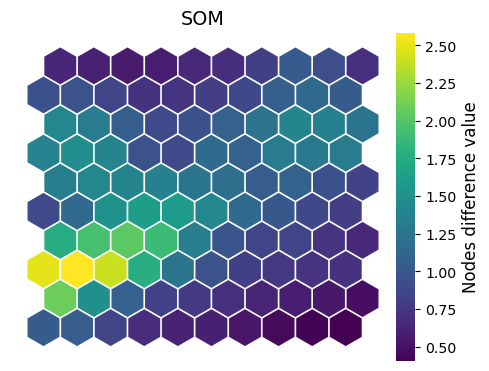

2024-09-30 18:46:36.076 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-09-30 18:46:36.108 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


0.014008653291942431


In [11]:
som_pca = sps.SOMNet(10, 10, pca_data, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=False, CUML=False,
                 debug=False)

som_pca.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som_pca.plot_map_by_difference(show=True, print_out=False)

som_pca_labels, _ = som_pca.cluster(pca_data, algorithm='KMeans', n_clusters=4)
print(adjusted_rand_score(labels, som_pca_labels))

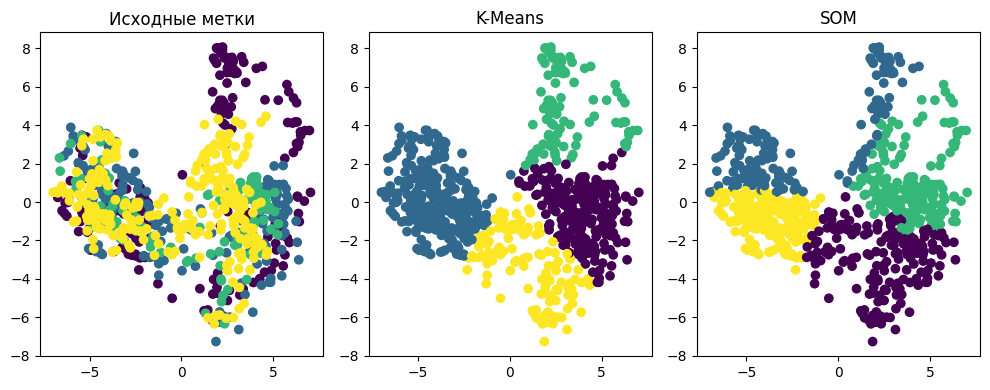

In [12]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(10)

axs[0].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=labels, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=k_means_pca_labels, cmap='viridis')
axs[1].set_title('K-Means')

axs[2].scatter(x=pca_data[:, 0], y=pca_data[:, 1], c=som_pca_labels, cmap='viridis')
axs[2].set_title('SOM')

plt.tight_layout()
plt.show()